In [1]:
using JLD2
file = jldopen("/Users/julios/two_dimensional_turbulence.jld2");
iterations = parse.(Int, keys(file["timeseries/t"]));
z = file["grid/zF"]; y = file["grid/yF"]; x = file["grid/xF"];
Lx = file["grid/Lx"];Ly = file["grid/Ly"]
Nx = file["grid/Nx"];Ny = file["grid/Ny"]
ω_snapshot = file["timeseries/ω/11"][:, :, 1];
ω = file["timeseries/ω"];
#size(ω_snapshot)
#iterations[2]
using Oceananigans, Oceananigans.Advection

grid = RegularCartesianGrid(size=(128, 128, 1), extent=(2π, 2π, 2π))

model = IncompressibleModel(timestepper = :RungeKutta3,
                              advection = UpwindBiasedFifthOrder(),
                                   grid = grid,
                               buoyancy = nothing,
                                tracers = nothing,
                                closure = IsotropicDiffusivity(ν=1e-5)
                                       )
using Statistics

u₀ = rand(size(model.grid)...)
u₀ .-= mean(u₀)
set!(model, u=u₀, v=u₀)

using Oceananigans.Fields, Oceananigans.AbstractOperations
u, v, w = model.velocities
ω = ∂x(v) - ∂y(u)
ω_field = ComputedField(ω)  
s = sqrt(u^2 + v^2)
s_field = ComputedField(s)

using Oceananigans.Grids

xω, yω, zω = nodes(ω_field)
xs, ys, zs = nodes(s_field)

┌ Info: Oceananigans will use 4 threads
└ @ Oceananigans /Users/julios/.julia/packages/Oceananigans/Mt2Rj/src/Oceananigans.jl:177


([-7.512787384681048e-18, 0.04908738521234051, 0.09817477042468102, 0.14726215563702152, 0.19634954084936204, 0.24543692606170256, 0.2945243112740431, 0.3436116964863836, 0.39269908169872414, 0.4417864669110646  …  5.792311455056181, 5.841398840268521, 5.890486225480862, 5.939573610693202, 5.988660995905543, 6.037748381117884, 6.086835766330224, 6.135923151542564, 6.185010536754905, 6.234097921967245], [0.02454369260617027, 0.07363107781851079, 0.12271846303085131, 0.17180584824319184, 0.22089323345553236, 0.2699806186678729, 0.3190680038802134, 0.3681553890925539, 0.4172427743048944, 0.46633015951723494  …  5.816855147662352, 5.865942532874692, 5.915029918087033, 5.964117303299373, 6.013204688511713, 6.062292073724055, 6.111379458936395, 6.160466844148735, 6.209554229361076, 6.258641614573416], [-3.141592653589793])

In [2]:
model.grid

RegularCartesianGrid{Float64, Periodic, Periodic, Bounded}
                   domain: x ∈ [-7.512787384681048e-18, 6.283185307179586], y ∈ [-7.512787384681048e-18, 6.283185307179586], z ∈ [-6.283185307179586, 0.0]
                 topology: (Periodic, Periodic, Bounded)
  resolution (Nx, Ny, Nz): (128, 128, 1)
   halo size (Hx, Hy, Hz): (3, 3, 3)
grid spacing (Δx, Δy, Δz): (0.04908738521234052, 0.04908738521234052, 6.283185307179586)

true

┌ Info: Making a neat movie of vorticity and speed...
└ @ Main In[7]:4
┌ Info: Plotting frame 1 from iteration 0...
└ @ Main In[7]:8
┌ Info: Plotting frame 2 from iteration 11...
└ @ Main In[7]:8
┌ Info: Plotting frame 3 from iteration 21...
└ @ Main In[7]:8
┌ Info: Plotting frame 4 from iteration 32...
└ @ Main In[7]:8
┌ Info: Plotting frame 5 from iteration 43...
└ @ Main In[7]:8
┌ Info: Plotting frame 6 from iteration 53...
└ @ Main In[7]:8
┌ Info: Plotting frame 7 from iteration 63...
└ @ Main In[7]:8
┌ Info: Plotting frame 8 from iteration 73...
└ @ Main In[7]:8
┌ Info: Plotting frame 9 from iteration 83...
└ @ Main In[7]:8
┌ Info: Plotting frame 10 from iteration 94...
└ @ Main In[7]:8
┌ Info: Plotting frame 11 from iteration 105...
└ @ Main In[7]:8
┌ Info: Plotting frame 12 from iteration 116...
└ @ Main In[7]:8
┌ Info: Plotting frame 13 from iteration 127...
└ @ Main In[7]:8
┌ Info: Plotting frame 14 from iteration 138...
└ @ Main In[7]:8
┌ Info: Plotting frame 15 from iteratio

Plots.AnimatedGif("/Users/julios/JULIA/anim_fps15.gif")
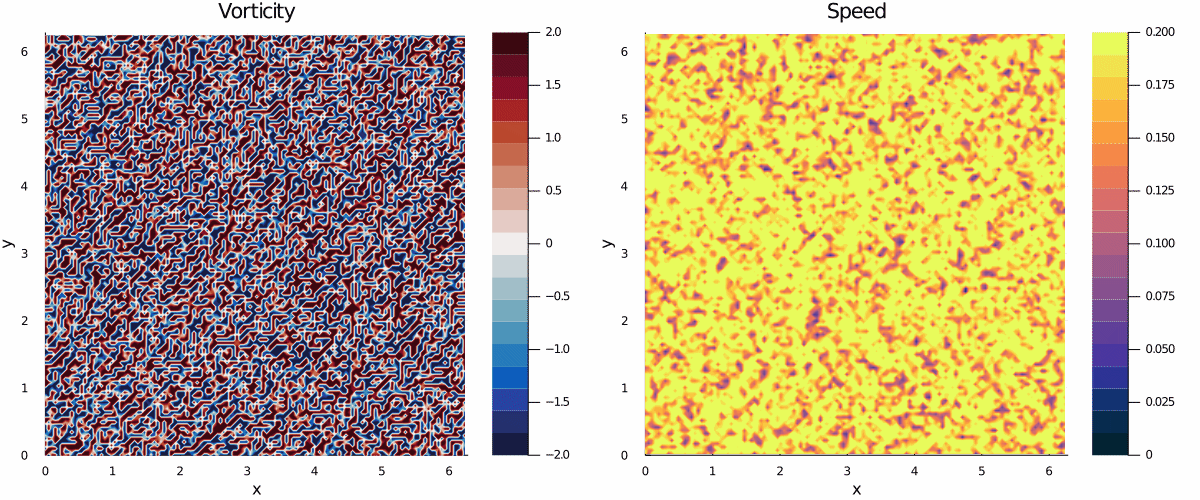

In [7]:
using Plots
show(true)

@info "Making a neat movie of vorticity and speed..."

anim = @animate for (i, iteration) in enumerate(iterations)

    @info "Plotting frame $i from iteration $iteration..."

    t = file["timeseries/t/$iteration"]
    ω_snapshot = file["timeseries/ω/$iteration"][:, :, 1]
    s_snapshot = file["timeseries/s/$iteration"][:, :, 1]

    ω_lim = 2.0
    ω_levels = range(-ω_lim, stop=ω_lim, length=20)

    s_lim = 0.2
    s_levels = range(0, stop=s_lim, length=20)

    kwargs = (xlabel="x", ylabel="y", aspectratio=1, linewidth=0, colorbar=true,
              xlims=(0, model.grid.Lx), ylims=(0, model.grid.Ly))

    ω_plot = contourf(xω, yω, clamp.(ω_snapshot', -ω_lim, ω_lim);
                       color = :balance,
                      levels = ω_levels,
                       clims = (-ω_lim, ω_lim),
                      kwargs...)

    s_plot = contourf(xs, ys, clamp.(s_snapshot', 0, s_lim);
                       color = :thermal,
                      levels = s_levels,
                       clims = (0, s_lim),
                      kwargs...)

    plot(ω_plot, s_plot, title=["Vorticity" "Speed"], layout=(1, 2), size=(1200, 500))
end
gif(anim, "anim_fps5.gif", fps = 5)